# Example of MMIHCL usage between strong linkage dataset integration.

In this tutorial, we demonstrate how to use MMIHCL to integrate a strong linkage dataset. 

Here, we use the CyTOF human H1N1 & IFNG dataset as an example.

In [1]:
# Import the necessary dependencies.
import torch
import warnings
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

from Model import *
from Utils import *
from Metrics import *
from LossUtils import *
from Preprocess import *
from Mmihcl import MMIHCL

plt.rcParams['figure.figsize'] = (6, 6)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Firstly read the dataset.
dataset_name = 'CyTOF_human'

shared_adata_1, shared_adata_2, all_adata_1, all_adata_2 = readDataset(dataset_name)

shared_adata_1, shared_adata_2, all_adata_1, all_adata_2

(AnnData object with n_obs × n_vars = 10000 × 39
     obs: 'celltype',
 AnnData object with n_obs × n_vars = 10000 × 39
     obs: 'celltype',
 AnnData object with n_obs × n_vars = 10000 × 41
     obs: 'celltype',
 AnnData object with n_obs × n_vars = 10000 × 40
     obs: 'celltype')

In [ ]:
# Then preprocess the dataset.
shared_adata_1, shared_adata_2, all_adata_1, all_adata_2 = preprocessAnnData(
    dataset_name=dataset_name,
    shared_adata_1=shared_adata_1,
    shared_adata_2=shared_adata_2,
    all_adata_1=all_adata_1,
    all_adata_2=all_adata_2,
    n_sample_1=10000,
    n_sample_2=10000
)

shared_adata_1, shared_adata_2, all_adata_1, all_adata_2

(AnnData object with n_obs × n_vars = 10000 × 39
     obs: 'celltype'
     var: 'mean', 'std',
 AnnData object with n_obs × n_vars = 10000 × 39
     obs: 'celltype'
     var: 'mean', 'std',
 AnnData object with n_obs × n_vars = 10000 × 41
     obs: 'celltype'
     var: 'mean', 'std',
 AnnData object with n_obs × n_vars = 10000 × 40
     obs: 'celltype'
     var: 'mean', 'std')

In [4]:
# Obtain cell annotation information from these AnnDatas for subsequent evaluation.
labels_1, labels_2 = getLabels(
    dataset_name=dataset_name,
    adata_1=shared_adata_1,
    adata_2=shared_adata_2
)

labels_1[:5], labels_2[:5]

(['NK', 'Neutrophil', 'B', 'Neutrophil', 'Neutrophil'],
 ['Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Neutrophil'])

In [5]:
# Generate MMIHCL object for integration.
MMI = MMIHCL(
    shared_array_1=shared_adata_1.X,
    shared_array_2=shared_adata_2.X,
    all_array_1=all_adata_1.X,
    all_array_2=all_adata_2.X
)

In [6]:
# Set the matching specifications.
MMI.setMatchingParameters(
    n_intermediate_match=1,
    n_final_match=1,
    verbose=True
)

We will perform one-to-one matching between two datasets.


In [7]:
# Construct graph matrices over all_array_1 and all_array_2.
MMI.constructGraph(
    n_neighbors_1=15,
    n_neighbors_2=15,
    n_components_1=30,
    n_components_2=30,
    verbose=True
)

Calculating adaptively k-neighbor adjacent matrices...
Two adaptively k-neighbor adjacent matrices have been calculated.
Calculating GCN aggregate matrices...
Two GCN aggregate matrices have been calculation calculated.


In [8]:
# Find initial matching between RNA and protein modalities.
MMI.findInitialMatching(
    hyperegde_dim=32,
    n_epochs=1000,
    n_layers=2,
    learn_rate=2e-2,
    weight_decay=1e-3,
    temp=0.1,
    min_dist=1e-7,
    threshold=0.7,
    verbose=True
)

print('The accuracy of initial matching is ' + str(evalAccuracy(MMI.init_matching, labels_1, labels_2) * 100) + '%.')

Learning shared feature embeddings...
Initializing the model and optimizer...


Fitting the model...
The hypergraph-based embedding learning is complete.
Finding the initial matching...
Filtering the initial matching...
The initial matching has been found and filtered.
The accuracy of initial matching is 91.25999999999999%.


In [9]:
# Find refined matching between RNA and protein modalities.
MMI.findRefinedMatching(
    hyperegde_dim=32,
    n_epochs=1000,
    n_layers=2,
    learn_rate=2e-2,
    weight_decay=1e-3,
    temp=0.1,
    min_dist=1e-7,
    threshold=0.7,
    n_iter=1,
    n_components=20,
    max_iter=1000,
    verbose=True
)

The current number of iterations: 1.
Using CCA projection to get joint embeddings...
Learning all feature embeddings......


In [10]:
# Find final matching between RNA and protein modalities and get joint embeddings.
MMI.findFinalMatching(
    min_dist=1e-7,
    threshold=0.7,
    n_components=20,
    max_iter=1000,
    verbose=True
)

Finding the final matching...
Filtering the final matching...
The final matching has been found and filtered.
Using CCA projection to get final joint embeddings...
The final joint embeddings have been geted.


In [11]:
# Evaluate the quality of the final joint embeddings.
cca_adata = ad.AnnData(
    np.concatenate((MMI.all_array_cca_1, MMI.all_array_cca_2), axis=0), 
    dtype=np.float32
)
cca_adata.obs['datatype'] = ['protein'] * MMI.all_array_cca_1.shape[0] + ['rna'] * MMI.all_array_cca_2.shape[0]
cca_adata.obs['celltype'] = labels_1 + labels_2

ACC = evalAccuracy(MMI.final_matching, labels_1, labels_2)
GC = evalGraphConnectivity(cca_adata.X, cca_adata.obs['celltype'])
ASW = evalAvgSilhouetteWidth(cca_adata.X, cca_adata.obs['celltype'])

print('The accuracy (ACC) of final matching is ' + str(ACC * 100) + '%.')
print('The graph connectivity (GC) of final joint embeddings is ' + str(GC) + '.')
print('The average silhouette width (ASW) of final joint embeddings is ' + str(ASW) + '.')

/public/home/zzp/anaconda3/envs/MMIHCL/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/public/home/zzp/anaconda3/envs/MMIHCL/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/public/home/zzp/MMIHCL/mmihcl/Metrics.py:74: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(c)


The accuracy (ACC) of final matching is 91.99000000000001%.
The graph connectivity (GC) of final joint embeddings is 0.9815667685845273.
The average silhouette width (ASW) of final joint embeddings is 0.6356848329305649.


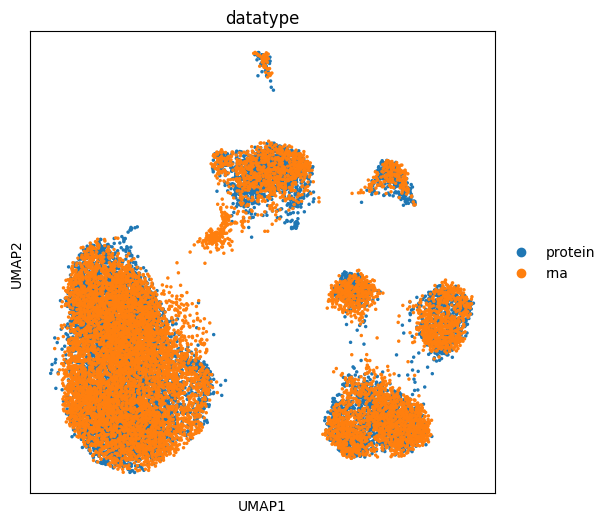

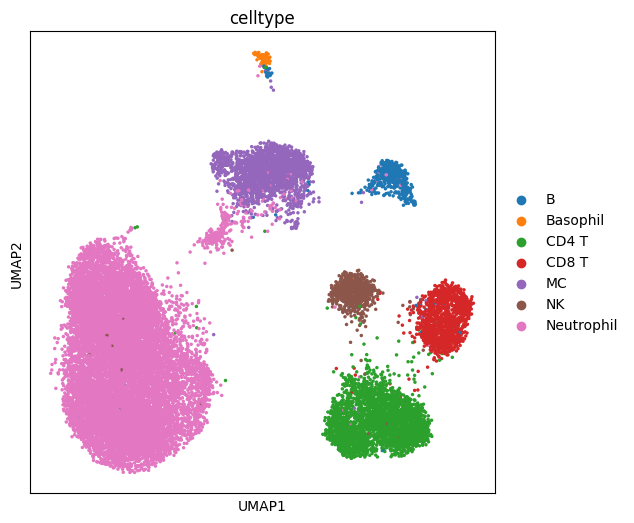

In [12]:
# Visualize the final joint embeddings using UMAP.
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)
sc.pl.umap(cca_adata, color='datatype', size=25)
sc.pl.umap(cca_adata, color='celltype', size=25)